# 準ニュートン法
引き続き、非線形最適化の手法について学習していきましょう。
今回は、ニュートン法においてその計算が必要であったヘッセ行列(の逆行列) の近似を、計算の過程で並行して求めることで、ニュートン法のような高速な収束性を、より少ない計算量で行うことのできる、**準ニュートン法**について扱います。
準ニュートン法に於けるヘッセ行列(の逆行列) の近似公式はいくつも知られていますが、ここではAnaconda に標準で添付されているSciPy において提供される、BFGS(Broyden-Fletcher-Goldfarb-Shanno) 公式による準ニュートン法について、その生成点列の挙動を確認しましょう。

In [1]:
import numpy as np
from scipy.optimize import line_search

def sdm(xk, iter=15):
    sequence = [xk]
    for k in range(iter):
        dk = -jac(xk)
        alpha = line_search(fun, jac, xk, dk)[0]
        xk = xk + alpha * dk
        sequence.append(xk)
    return np.array(sequence)

## 目的関数
今回も、前々回、前回と扱ってきた、
\begin{align*}
f(x_0, x_1):=\sin\left(\frac{1}{2}x_0^2-\frac{1}{4}x_1^2+3\right)\cos(2x_0+1-e^{x_1})
\end{align*}
を目的関数として考えましょう。
この関数は、前回確認した通り、下記のような複雑な形状をしていました。

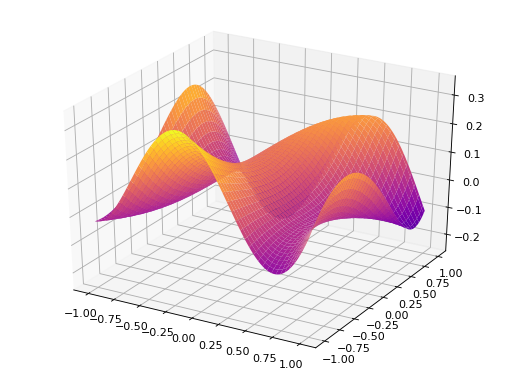

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
Z = np.array([[np.sin((x ** 2) / 2 - (y ** 2 ) / 4 + 3) * np.cos(2 * x + 1 - np.exp(y)) for x, y in zip(vx, vy)] for vx, vy in zip(X, Y)])
ax.plot_surface(X, Y, Z, cmap='plasma')

この目的関数`fun` およびその勾配`jac` は、それぞれ下記のようにPython 関数として書き下すことができました。

In [3]:
import numpy as np

def fun(x):
    return np.sin((x[0] ** 2) / 2 - (x[1] ** 2 ) / 4 + 3) * np.cos(2 * x[0] + 1 - np.exp(x[1]))

def jac(x):
    u, v = (x[0] ** 2) / 2 - (x[1] ** 2 ) / 4 + 3, 2 * x[0] + 1 - np.exp(x[1])
    return np.array([
        x[0] * np.cos(u) * np.cos(v) - 2 * np.sin(u) * np.sin(v),
        np.exp(x[1]) * np.sin(u) * np.sin(v) - (x[1] / 2) * np.cos(u) * np.cos(v)
    ])

## BFGS 公式による準ニュートン法
それでは早速、実験をしてみましょう。
BFGS 公式による準ニュートン法は、下記の関数により実行することができます。
```python
from scipy.optimize import minimize
x = minimize(fun, x0, method='bfgs', jac=jac).x
```
前回の信頼領域法と同様に、``scipy.optimize`` モジュールの``minimize`` 関数より、最適化アルゴリズムを呼び出すことができます。
信頼領域法と異なり、ヘッセ行列を指定する必要はなく、目的関数``fun``、初期点``x0`` および勾配``jac`` を与えることで実行できます。
それでは早速、生成点列の挙動を確認してみましょう。
初期点は前回までと同様に、$x^{(0)}:=(-0.3, 0.2)^\top$ を与えるものとします。

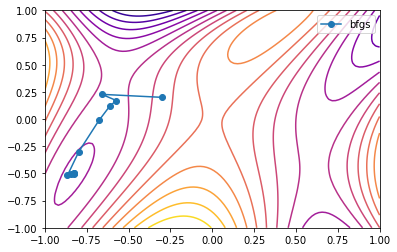

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
plt.ylim(-1, 1)
plt.xlim(-1, 1)
Z = np.array([[np.sin((x ** 2) / 2 - (y ** 2 ) / 4 + 3) * np.cos(2 * x + 1 - np.exp(y)) for x, y in zip(vx, vy)] for vx, vy in zip(X, Y)])
plt.contour(X, Y, Z, cmap='plasma', levels=np.linspace(np.min(Z), np.max(Z), 15))
sequence = [np.array([-0.3, 0.2])]
minimize(fun, sequence[0], method='bfgs', jac=jac, callback=lambda xk: sequence.append(xk))
sequence = np.array(sequence)
plt.plot(sequence[:, 0], sequence[:, 1], marker='o', label='bfgs')
plt.legend()

生成点列については、多少の振動は起きていますが、最急降下法のような極端な振動はなく、比較的効率的に最適解へ収束していることが見て取れます。

## 参考文献
  * 福島雅夫著『新版　数理計画入門』(朝倉書店; 2011)
  * 矢部博著『工学基礎　最適化とその応用』(数理工学社; 2006)
  * J. Nocedal, S. J. Wright: Numerical Optimization (2nd ed.), Springer (2006)
  * [Gradient descent - Wikipedia](https://en.wikipedia.org/wiki/Gradient_descent) (目的関数はこのページのものを使用しました。)